In [1]:
# transform one data to another
import json
import os
import numpy as np
def loadjsonl(fn, to_alpaca_format = True):
    """
        add to experiments_utils/utils
    """
    return [json.loads(i) for i in open(fn, 'r').read().split('\n') if i!= '']

def jsonl_t2c_to_instruction_format(dct, 
                                    sep_token='\n', 
                                    prompt='Generate java code'
                                   ):
    """
        add to experiments_utils/utils
    """
    instruction, input_str1, input_str2 = dct['nl'].split('concode_field_sep')

    instruction = instruction.replace("concode_elem_sep", sep_token)
    instruction = prompt+'\n'+instruction
    input_str = input_str1 + '\n' + sep_token + input_str2
    input_str = input_str.replace("concode_elem_sep", sep_token)
    
    res = {"instruction": instruction,
           "input": input_str,
           "output": dct['code']
          }

    return res

# # testing
# # test everything
# input_file = "/root/CodeXGLUE/Text-Code/text-to-code/evaluator/answers.json" # 100
# # input_file = "/root/CodeXGLUE/Text-Code/text-to-code/dataset/concode/train.json" # 100000
# # input_file = "/root/CodeXGLUE/Text-Code/text-to-code/dataset/concode/test.json" # 2000
# # input_file = "/root/CodeXGLUE/Text-Code/text-to-code/dataset/concode/dev.json" # 2000

# lst_original = loadjsonl(input_file)
# # transform to alpace format
# lst_original = [jsonl_t2c_to_instruction_format(i) for i in lst_original]
# len(lst_original)

# show original alpaca
# alpaca_original = json.load(open("alpaca_data.json", "r"))
# alpaca_original = json.load(open("alpaca_data.json", "r"))

In [2]:
def create_folder_if_not_exist(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [3]:
output_path = "t2c_concode"
create_folder_if_not_exist(output_path)

train_file_cofig = [("/root/CodeXGLUE/Text-Code/text-to-code/evaluator/answers.json", "t2c_answers.json"),
                    ("/root/CodeXGLUE/Text-Code/text-to-code/dataset/concode/train.json", "t2c_train.json"),
                    ("/root/CodeXGLUE/Text-Code/text-to-code/dataset/concode/test.json", "t2c_test.json"),
                    ("/root/CodeXGLUE/Text-Code/text-to-code/dataset/concode/dev.json", "t2c_dev.json")
                   ]
for input_file, file_output in train_file_cofig:
    print("Trandform_file", input_file)
    lst = loadjsonl(input_file)
    lst = [jsonl_t2c_to_instruction_format(i) for i in lst]
    
    fn_output = os.path.join(output_path, file_output)
    print("Saving", fn_output)
    json.dump(lst, open(fn_output, 'w+'))
#     print(file_output, lst[0])

Trandform_file /root/CodeXGLUE/Text-Code/text-to-code/evaluator/answers.json
Saving t2c_concode/t2c_answers.json
Trandform_file /root/CodeXGLUE/Text-Code/text-to-code/dataset/concode/train.json
Saving t2c_concode/t2c_train.json
Trandform_file /root/CodeXGLUE/Text-Code/text-to-code/dataset/concode/test.json
Saving t2c_concode/t2c_test.json
Trandform_file /root/CodeXGLUE/Text-Code/text-to-code/dataset/concode/dev.json
Saving t2c_concode/t2c_dev.json


In [4]:
from datasets import load_dataset
from transformers import LLaMATokenizer
import matplotlib.pyplot as plt



tokenizer = LLaMATokenizer.from_pretrained(
    "decapoda-research/llama-7b-hf", add_eos_token=True
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id


In [5]:
# file_input = "alpaca_data.json"

def generate_prompt(data_point):
    # sorry about the formatting disaster gotta move fast
    if data_point["input"]:
        return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{data_point["instruction"]}

### Input:
{data_point["input"]}

### Response:
{data_point["output"]}"""
    else:
        return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
### Instruction:
{data_point["instruction"]}

### Response:
{data_point["output"]}"""

def draw_bpe_tokens_histogram(file_input, 
                              cutoff_list = [256],
                              output_img_folder = "img"
                             ):
    dataset_name = file_input.split('/')[-1].split('.')[0]
    
    if isinstance(cutoff_list, int):
        cutoff_list = [cutoff_list]
    
    data = load_dataset("json", data_files=file_input)


    data = data.map(
        lambda data_point: {"prompt": tokenizer(generate_prompt(data_point))}
    )


    lens = np.array([len(x["prompt"]["input_ids"]) for x in data["train"]])
    plt.title("filename: %s"%file_input)
    plt.hist(lens, bins=100)
    plt.title("Distribution of prompt lengths")
    for cutoff in cutoff_list:
        plt.axvline(cutoff, 
                    label = "cutoff=%2.2f, <=cutoff: %2.2f%%"%(cutoff, np.mean(lens<cutoff)*100)
                   )
    plt.legend()
    if output_img_folder is not None:
        plt.savefig(os.path.join(output_img_folder, 
                                 dataset_name + "distribution_prompt.png")
                   )
    plt.show()


    plt.title("filename: %s"%file_input)
    lst = np.array([len([l for l in lens if l <= m]) for m in range(max(lens) + 1)])
    plt.plot(lst)
    plt.title("Number of fully covered examples as a function of max length")
    for cutoff in cutoff_list:
        plt.axvline(cutoff, 
                    label = "cutoff=%2.2f, <=cutoff: %2.2f%%"%(cutoff, np.mean(lst<cutoff)*100)
                   )
    plt.legend()
    if output_img_folder is not None:
        plt.savefig(os.path.join(output_img_folder,
                                 dataset_name +  "number_of_fully_covered_examples.png")
                   )
    plt.show()

    plt.title("filename: %s"%file_input)
    lst = np.array([sum(min(l, m) for l in lens) for m in range(max(lens) + 1)])
    plt.plot(lst)
    plt.title("Token coverage as a function of max length")
    for cutoff in cutoff_list:
        plt.axvline(cutoff, 
                    label = "cutoff=%2.2f, <=cutoff: %2.2f%%"%(cutoff, np.mean(lst<cutoff)*100)
                   )
    plt.legend()
    if output_img_folder is not None:
        plt.savefig(os.path.join(output_img_folder,        
                                 dataset_name + "token_coverage.png"
                                )
                   )
    plt.show()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-2f6ce9a600398811/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

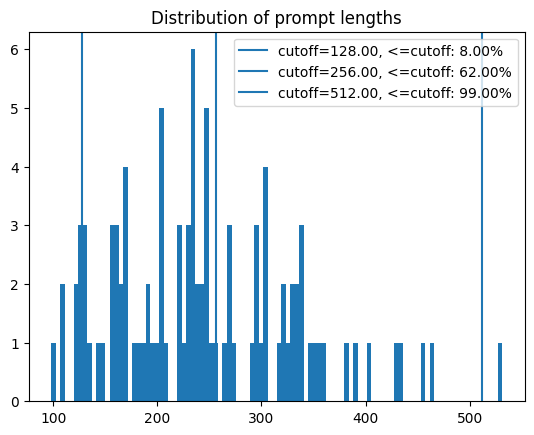

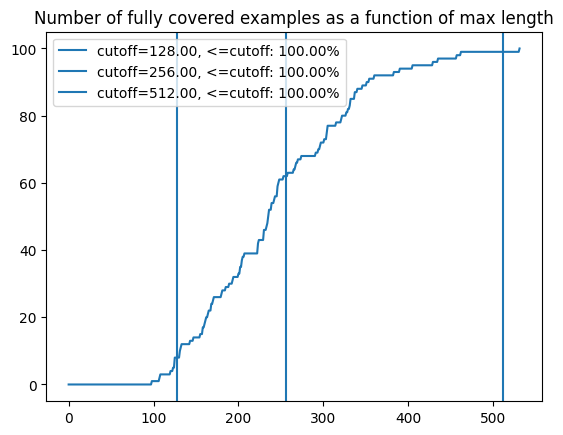

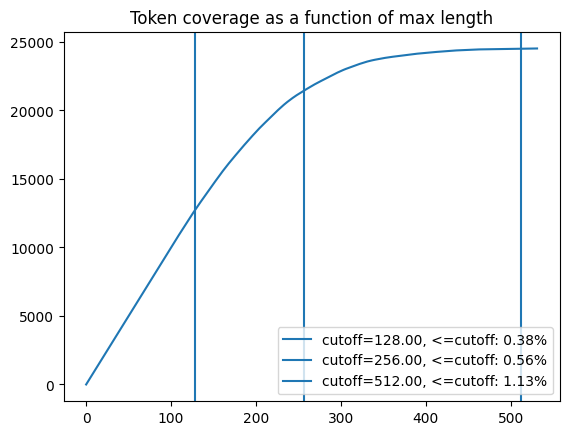

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-e0f3b1cf59a37edd/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

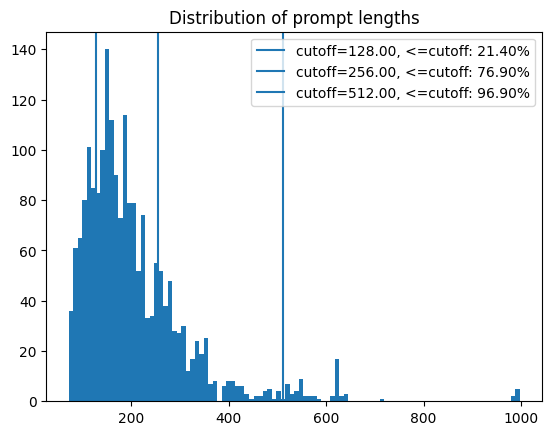

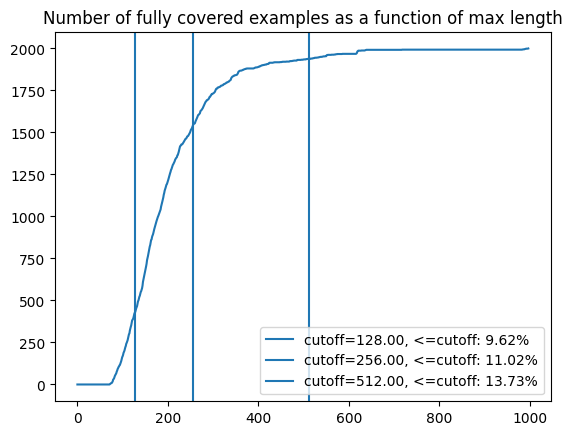

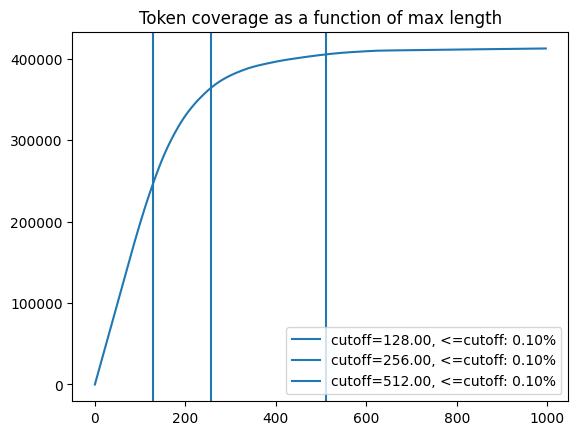

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-e3a5e532eb1eb6e4/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

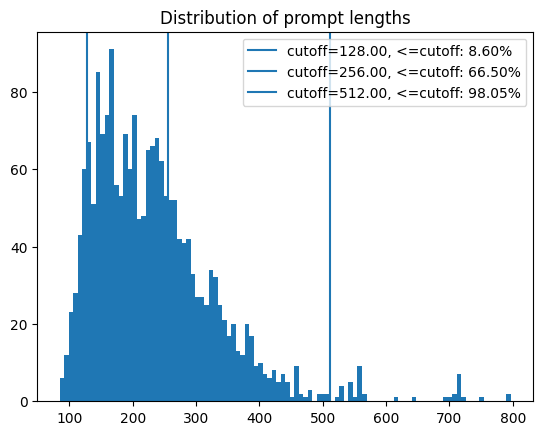

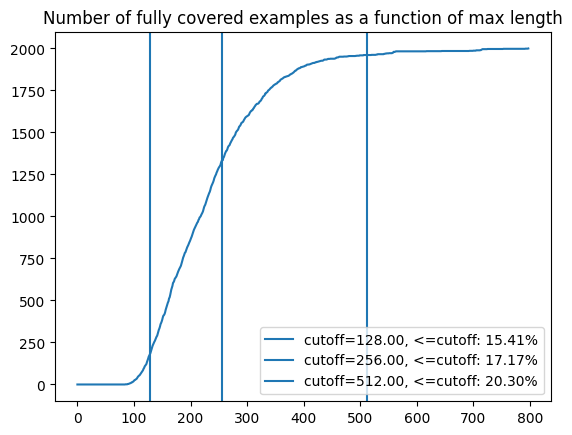

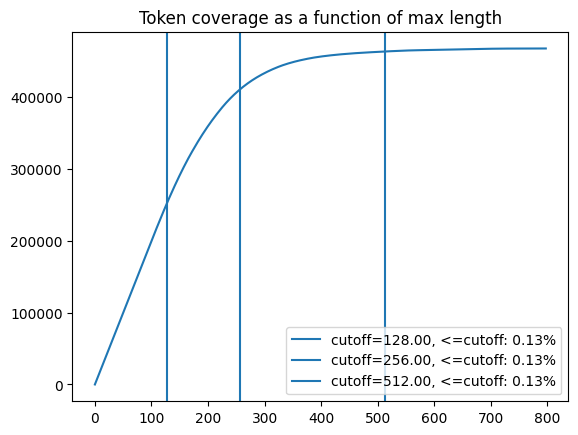

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-5d27b2ac09210c18/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

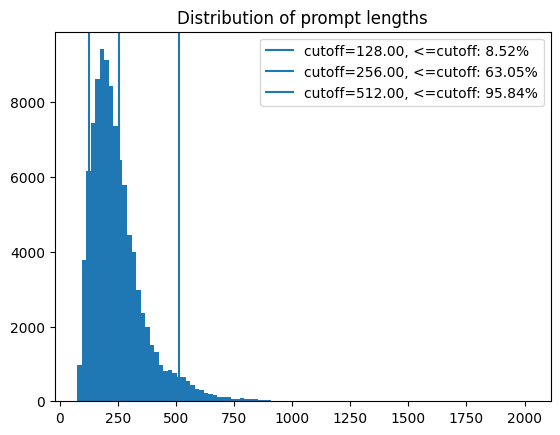

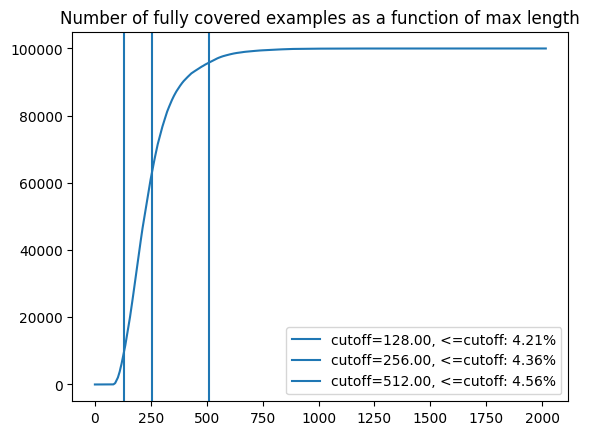

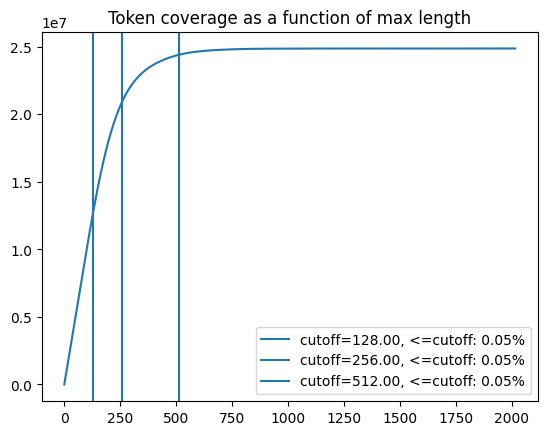

Found cached dataset json (/root/.cache/huggingface/datasets/json/default-417dee54c2057778/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/json/default-417dee54c2057778/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-39359128ab002c84.arrow


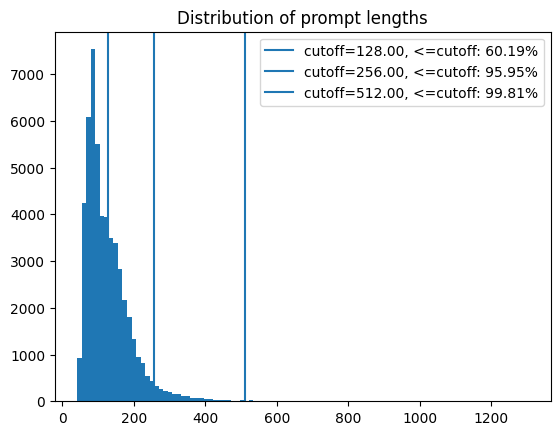

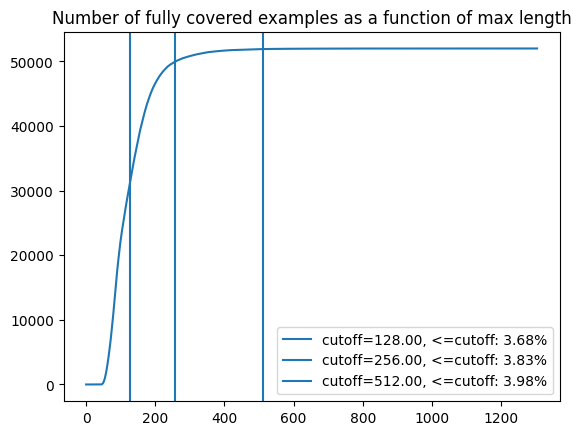

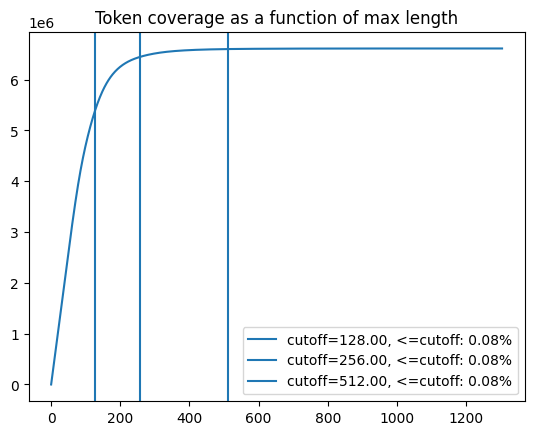

In [6]:
create_folder_if_not_exist('img')
for file_input in ["from transformers import AutoTokenizer, AutoConfig, LLaMAForCausalLM, LLaMATokenizer",
                   "t2c_concode/t2c_test.json",
                   "t2c_concode/t2c_dev.json",
                   "t2c_concode/t2c_train.json",
                   "alpaca_data.json"
                  ]:
    draw_bpe_tokens_histogram(file_input, [128, 256, 512])

In [7]:
from transformers import LLaMAForCausalLM, LLaMATokenizer